In [6]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [7]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [8]:
# import os
# os.chdir('C:\\Users\\Dell\\Desktop\\Emotion_detection\\data')

In [9]:
data_train = pd.read_csv('C:\\Users\\Dell\\Desktop\\Emotion_detection\\data\\data_train.csv', encoding='utf-8')
data_test = pd.read_csv('C:\\Users\\Dell\\Desktop\\Emotion_detection\\data\\data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_19544\2452826379.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_train.append(data_test, ignore_index=True)


In [10]:
data_train.head()

,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


In [11]:
data_test.head()

,Emotion,Text
0,sadness,I experienced this emotion when my grandfather...
1,neutral,"when I first moved in , I walked everywhere ...."
2,anger,"` Oh ! "" she bleated , her voice high and rath..."
3,fear,"However , does the right hon. Gentleman recogn..."
4,sadness,My boyfriend didn't turn up after promising th...


In [12]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


In [13]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [14]:

import nltk
nltk.download('punkt')
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


In [17]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]])

In [18]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [19]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [20]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath ,encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [21]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [22]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

In [23]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


In [24]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [25]:

# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
model.get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 3,957,925
Trainable params: 331,525
Non-trainable params: 3,626,400
_________________________________________________________________


[array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [-0.3116,  0.0856, -0.0069, ...,  0.0877,  0.1019,  0.0097],
        [ 0.0897,  0.016 , -0.0571, ...,  0.1559, -0.0254, -0.0259],
        ...,
        [-0.0161, -0.121 , -0.1894, ...,  0.2269, -0.0527,  0.1604],
        [-0.0435,  0.1515, -0.03  , ...,  0.1261,  0.069 , -0.0373],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
       dtype=float32),
 array([[ 0.06407963,  0.08058612,  0.00646412, ..., -0.00629073,
          0.00512088,  0.04815525],
        [-0.07476857,  0.05501558,  0.03936836, ...,  0.08512048,
          0.07239936, -0.0042539 ],
        [ 0.03357913, -0.07264157, -0.08698021, ...,  0.02945543,
         -0.02320443,  0.02930859],
        ...,
        [-0.08579686, -0.03344126,  0.02856848, ..., -0.05404519,
          0.04498737,  0.01475926],
        [-0.02820317,  0.04487982,  0.01574435, ..., -0.03621736,
         -0.01707993,  0.07553901],
        [-0.02335679,  0.0

In [28]:
import mlflow
from mlflow import log_metric
from time import time
import mlflow.keras

In [29]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [30]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'sqlite:///mlflow.db'


mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [31]:
mlflow.set_experiment("my-experiment-1")
mlflow.list_experiments()

2022/07/10 14:38:59 INFO mlflow.tracking.fluent: Experiment with name 'my-experiment-1' does not exist. Creating a new experiment.


[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='my-experiment-1', tags={}>]

In [32]:
mlflow.tensorflow.autolog(log_models=True)

In [34]:
mlflow.end_run()

In [33]:
mlflow.start_run()
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))
# mlflow.start_run()
# mlflow.keras.log_model(model, "model")
# mlflow.keras.save_model(model,"model")
from urllib.parse import parse_qsl, urljoin, urlparse
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme



if tracking_url_type_store != "file":
          mlflow.keras.log_model(model, "model", registered_model_name="Keras")
        #   mlflow.sklearn.save_model(model,"models")

else:

          mlflow.keras.log_model(model, "model")
        #   mlflow.sklearn.save_model(model,"models")
    

Epoch 1/15
62/62 [==============================] - 1689s 27s/step - loss: 1.3956 - accuracy: 0.3843 - val_loss: 1.2783 - val_accuracy: 0.4556
Epoch 2/15
62/62 [==============================] - 2227s 36s/step - loss: 1.1220 - accuracy: 0.5584 - val_loss: 1.0010 - val_accuracy: 0.6104
Epoch 3/15
62/62 [==============================] - 2695s 44s/step - loss: 0.8866 - accuracy: 0.6691 - val_loss: 0.8420 - val_accuracy: 0.6899
Epoch 4/15
62/62 [==============================] - 3018s 49s/step - loss: 0.7923 - accuracy: 0.7157 - val_loss: 0.8103 - val_accuracy: 0.7044
Epoch 5/15
62/62 [==============================] - 3257s 53s/step - loss: 0.7482 - accuracy: 0.7349 - val_loss: 0.8020 - val_accuracy: 0.7020
Epoch 6/15
62/62 [==============================] - 3446s 56s/step - loss: 0.7141 - accuracy: 0.7448 - val_loss: 0.7618 - val_accuracy: 0.7233
Epoch 7/15
62/62 [==============================] - 3602s 58s/step - loss: 0.6886 - accuracy: 0.7551 - val_loss: 0.7804 - val_accuracy: 0.7138

Successfully registered model 'Keras'.
2022/07/11 04:50:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Keras, version 1
Created version '1' of model 'Keras'.


mlflow.keras.save_model(model,"model")

In [ ]:
from urllib.parse import parse_qsl, urljoin, urlparse
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme



if tracking_url_type_store != "file":
        
          mlflow.keras.save_model(model, "modelss", registered_model_name="Keras")
        #   mlflow.sklearn.save_model(model,"models")
          

else:

          mlflow.keras.save_model(model, "modelss")

INFO:tensorflow:Assets written to: c:\Users\Dell\Desktop\Emotion_detection\modelss\data\model\assets


In [ ]:
mlflow.sklearn.save_model(model,"modelss")

INFO:tensorflow:Assets written to: ram://a72eacce-f51b-4d33-95fc-a4ac37b082b5/assets


2022/06/24 13:30:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: modelss\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [ ]:
path=mlflow.tracking.get_tracking_uri()
print (path)

file:///C:/Users/Dell/Desktop/Emotion_detection/mlruns


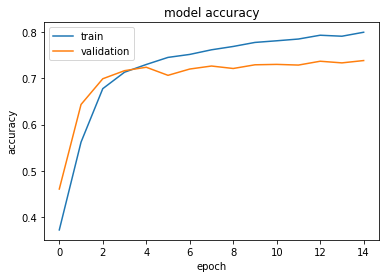

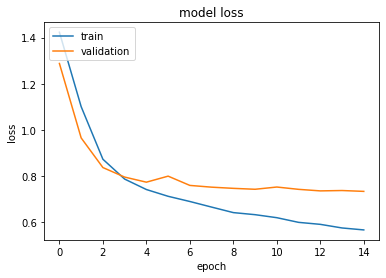

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

107/107 [==============================] - 282s 3s/step


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 74.86%

F1 Score: 74.86


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 74.86


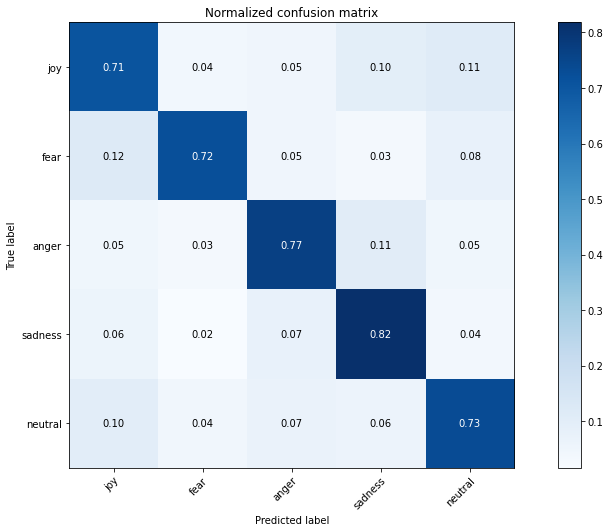

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [ ]:
import time
import re
# sentence = 'I really like python. it is worst day'
sentence = 'Emotion plays a major role in influencing our behaviour. Life would be dreary without feelings like joy and sorrow, excitement and disappointment, love and fear, hope and dismay. Emotion adds colour and spice to life.'
def prediction_by_list(sentence):
# sentence = 'I really like python. it is worst day'
  sen = re.split("(?<!\d)[,.?](?!\d)",sentence)
  pred_result=[]
  print(sen)
  result_message=[]



  for i in sen:
    messag = i
    # print(messag)
    message=[]
    message.append(i)
    
    # print(message)
    # lis = 
    seq = tokenizer.texts_to_sequences(message)
    padded = pad_sequences(seq, maxlen=max_seq_len)

    start_time = time.time()
    pred = model.predict(padded)

    a=('Message: ' + str(message))
    b=('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))
    pred_result.append(b)
    result_message.append(a)

  def countList(result_message, pred_result):
    return [sub[item] for item in range(len(pred_result))
                      for sub in [result_message, pred_result]]
  
  return(countList(result_message, pred_result))
  
prediction_by_list(sentence)

['Emotion plays a major role in influencing our behaviour', ' Life would be dreary without feelings like joy and sorrow', ' excitement and disappointment', ' love and fear', ' hope and dismay', ' Emotion adds colour and spice to life', '']
1/1 [==============================] - 1s 1s/step


["Message: ['Emotion plays a major role in influencing our behaviour']",
 'predicted: fear (1.62 seconds)',
 "Message: [' Life would be dreary without feelings like joy and sorrow']",
 'predicted: sadness (1.58 seconds)',
 "Message: [' excitement and disappointment']",
 'predicted: joy (1.56 seconds)',
 "Message: [' love and fear']",
 'predicted: fear (1.54 seconds)',
 "Message: [' hope and dismay']",
 'predicted: fear (1.51 seconds)',
 "Message: [' Emotion adds colour and spice to life']",
 'predicted: joy (1.50 seconds)',
 "Message: ['']",
 'predicted: neutral (1.48 seconds)']

In [ ]:
from tensorflow import keras

In [ ]:
model.save('trail_model.h5')

In [ ]:
import os
os.chdir('C:\\Users\\Dell\\Desktop\\Emotion_detection\\data')

In [ ]:
from keras.models import load_model
new_model = load_model('trail_model.h5')

In [ ]:
import time
import re
# sentence = 'I really like python. it is worst day'
sentence = 'Emotion plays a major role in influencing our behaviour. Life would be dreary without feelings like joy and sorrow, excitement and disappointment, love and fear, hope and dismay. Emotion adds colour and spice to life.'
def prediction_by_list(sentence):
# sentence = 'I really like python. it is worst day'
  sen = re.split("(?<!\d)[,.?](?!\d)",sentence)
  pred_result=[]
  print(sen)
  result_message=[]



  for i in sen:
    messag = i
    # print(messag)
    message=[]
    message.append(i)
    
    # print(message)
    # lis = 
    seq = tokenizer.texts_to_sequences(message)
    padded = pad_sequences(seq, maxlen=max_seq_len)

    start_time = time.time()
    pred = new_model.predict(padded)

    a=('Message: ' + str(message))
    b=('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))
    pred_result.append(b)
    result_message.append(a)

  def countList(result_message, pred_result):
    return [sub[item] for item in range(len(pred_result))
                      for sub in [result_message, pred_result]]
  
  return(countList(result_message, pred_result))
  
prediction_by_list(sentence)

['Emotion plays a major role in influencing our behaviour', ' Life would be dreary without feelings like joy and sorrow', ' excitement and disappointment', ' love and fear', ' hope and dismay', ' Emotion adds colour and spice to life', '']
1/1 [==============================] - 2s 2s/step


["Message: ['Emotion plays a major role in influencing our behaviour']",
 'predicted: fear (2.64 seconds)',
 "Message: [' Life would be dreary without feelings like joy and sorrow']",
 'predicted: sadness (1.75 seconds)',
 "Message: [' excitement and disappointment']",
 'predicted: joy (1.67 seconds)',
 "Message: [' love and fear']",
 'predicted: fear (1.65 seconds)',
 "Message: [' hope and dismay']",
 'predicted: fear (1.67 seconds)',
 "Message: [' Emotion adds colour and spice to life']",
 'predicted: joy (1.63 seconds)',
 "Message: ['']",
 'predicted: neutral (1.66 seconds)']